# Mnist-Client

****User****: 
- *Call Batch Inference*
    1. Upload a bunch of data to a directory
    2. data directory as a parameter to the batch inference
    3. run batch-inference workflow
- *Call Online Inference*
    1. Prepare a single data
    2. send request to online-inference by using seldonclient

## Batch-inference Client

for batch-inference client, client similar as we did in dataengineer team, client could call 'run_workflow'.

In [16]:
await deployerClient.run_workflow(app_name='mnist', 
                                  team_name='dataengineer',
                                  workflow = build_app.workflows[0])

25-May-21 15:58:22 -  INFO - [+] output dir /workflow
25-May-21 15:58:22 -  INFO - [+] Create batch-inference output PV
25-May-21 15:58:22 -  INFO - create_pv true
25-May-21 15:58:22 -  INFO - [+] Create batch-inference output PVC
25-May-21 15:58:22 -  INFO - create_pvc true
25-May-21 15:58:22 -  INFO - output dir created
25-May-21 15:58:22 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'admin', 'AWS_SECRET_ACCESS_KEY': 'admin123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.minio-system.svc.cluster.local:9000', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-system.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-system.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mnist-dataengineer.svc.cluster.local'}
25-May-21 15:58:22 -  INFO - [+] Building workflow: [batch-inference:load-data].
25-May-21 15:58:22 -  INFO - ['--app_name', 'mnist', '--team_name', 'data']
25-May-21 15:58:22 -  INFO - [+] Buildin

OrderedDict([('apiVersion', 'argoproj.io/v1alpha1'), ('kind', 'Workflow'), ('metadata', {'name': 'batch-inference'}), ('spec', {'entrypoint': 'batch-inference', 'volumes': [OrderedDict([('name', 'outputpath'), ('persistentVolumeClaim', {'claimName': 'batch-inference'})]), OrderedDict([('name', 'scanflowpath'), ('persistentVolumeClaim', {'claimName': 'scanflow-scanflow-mnist-dataengineer'})])], 'templates': [OrderedDict([('name', 'batch-inference'), ('dag', {'tasks': [OrderedDict([('name', 'load-data'), ('template', 'load-data'), ('arguments', OrderedDict([('parameters', [{'name': 'para-load-data-0', 'value': '--app_name'}, {'name': 'para-load-data-1', 'value': 'mnist'}, {'name': 'para-load-data-2', 'value': '--team_name'}, {'name': 'para-load-data-3', 'value': 'data'}])]))]), OrderedDict([('name', 'predictor-batch'), ('dependencies', ['load-data']), ('template', 'predictor-batch'), ('arguments', OrderedDict([('parameters', [{'name': 'para-predictor-batch-0', 'value': '--model_name'}, {

True

## Online-inference Client

for online-inference client, client uses seldonClient to send requests.

In [1]:
from seldon_core.seldon_client import SeldonClient
import tensorflow as tf

In [2]:
model = tf.saved_model.load("model", tags=None, options=None)

In [3]:
signatures = list(model.signatures.keys())
print(signatures)

['serving_default']


In [4]:
##Tips: the parameter model_name,input,output should be the same as defined inside signature.
infer = model.signatures['serving_default']
print(infer)

ConcreteFunction signature_wrapper(*, input_1)
  Args:
    input_1: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    {'dense_1': <1>}
      <1>: float32 Tensor, shape=(None, 10)


In [5]:
sc = SeldonClient(deployment_name="online-inference", \
                  namespace="scanflow-mnist-dataengineer", \
                  gateway="istio", \
                  gateway_endpoint="172.30.0.50:40000", payload_type='tftensor', transport="grpc", \
                  client_return_type="proto", \
                  grpc_max_send_message_length=419430400, grpc_max_receive_message_length=419430400)

(1, 28, 28)


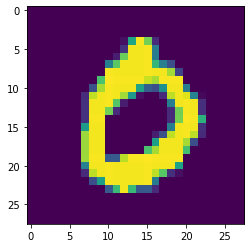

In [6]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

image_shape = (28,28)
img = Image.open("0-0.png")
plt.imshow(img)
img = np.expand_dims(img.resize(image_shape), axis=0)
img = np.asarray(img, dtype='float32')
# print(img)
print(img.shape)

In [7]:
imagereshape = img.reshape(1, 28, 28, 1)
print(imagereshape.shape)

(1, 28, 28, 1)


In [8]:
r = sc.predict(data=imagereshape)
# print(r)
preds = tf.make_ndarray(r.response.data.tftensor)

In [9]:
print(preds)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
